In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import random
import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

import copy

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# For Data Augmentation
from torchvision import transforms as tr
from torchvision.transforms import Compose
from PIL import Image

# For VGG Classifier
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, ZeroPadding2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers.normalization import BatchNormalization

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0876133, r0876755, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:

0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    './kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    './kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('./kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('./kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [ ]:
# The training set contains an identifier, name, image information and class label
train.head(1)

In [ ]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

In [ ]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [3]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        norm_img = np.zeros((FACE_SIZE[0], FACE_SIZE[1]))
        img_gray = cv2.normalize(img_gray, norm_img, 0, 255, cv2.NORM_MINMAX)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.25,
            minNeighbors=4,
            minSize=(40, 40),
            flags=cv2.CASCADE_SCALE_IMAGE  
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

DNNPreprocessor improves the HAARPreprocessor. Probably best performing face detector.

In [4]:
class DNNPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, face_size):
        self.face_size = face_size
        self.modelFile = "./models/opencv_face_detector.caffemodel"
        self.configFile = "./models/deploy.prototxt.txt"
        self.net = cv2.dnn.readNetFromCaffe(self.configFile, self.modelFile)
        self.default_confidence = 0.5
    
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,(300, 300), (104.0, 117.0, 123.0))
        self.net.setInput(blob)
        return self.net.forward()
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        confidence = self.default_confidence
        faces = []
        h, w = img.shape[:2]
        f = self.detect_faces(img)
        #to draw faces on image
        for i in range(f.shape[2]):
                c = f[0, 0, i, 2]
                if c > confidence and confidence == 0.5:
                    faces.append((f[0, 0, i, 3:7] * np.array([w, h, w, h])).astype("int"))
                    confidence = c
                elif c > confidence and confidence != 0.5:
                    faces.pop()
                    faces.append((f[0, 0, i, 3:7] * np.array([w, h, w, h])).astype("int"))
                    confidence = c
                    
        return [img[y:y1, x:x1]  for (x, y, x1, y1) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [36]:
# parameter to play with 
FACE_SIZE = (224, 224)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i].astype('uint8'))
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i].astype('uint8'))
        else:
            ax[int(i%n)].imshow(data[i].astype('uint8'))
    plt.show()

    
#preprocessed data 
preprocessor = DNNPreprocessor(face_size=FACE_SIZE)

train_modified = copy.deepcopy(train)

# #train_set preprocessing to improve the performance of the face_detector.
# #Double face in a single image are removed. 
train_img = train_modified['img'].values
train_img[5] = train_img[5][0:400, :]
train_img[70] = train_img[70][:, 150:]
train_img[61] = train_img[61][:, 100:]
train_img[60] = train_img[60][0:1500,:]
train_img[59] = train_img[59][:, 200:]
train_img[53] = train_img[53][:, 250:]
train_img[52] = train_img[52][:, 300:]
train_img[50] = train_img[50][0:300,:]
train_img[49] = train_img[49][:, 0:150]
train_img[41] = train_img[41][:, 0:200]
train_img[39] = train_img[39][:, 125:225]
train_img[40] = train_img[40][:, 100:]
train_img[34] = train_img[34][:, 200:400]
train_img[29] = train_img[29][:, :400]
train_img[28] = train_img[28][:, 0:500]
train_img[18] = train_img[18][:, :250]

train_X, train_y = preprocessor(train_modified), train['class'].values

#Image65 is wrong (total black), so it is eliminated
train_X = np.delete(train_X, 65, axis=0)
train_y = np.delete(train_y, 65, axis=0)

test_X = preprocessor(test)

In [ ]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=train_X[train_y == 0].shape[0], imgs_per_row=10)

In [ ]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=train_X[train_y == 1].shape[0], imgs_per_row=10)

In [ ]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=train_X[train_y == 2].shape[0], imgs_per_row=10)


## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

Data after data augmentation can be stored using the code in this cell.

In [ ]:
prep_path = './kaggle/working/prepped_data/'

In [ ]:
# save preprocessed data
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

In [ ]:
# load preprocessed data
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

## 0.5 Data Augmentation

### Data Augmentation: image flip

The plot below explains the flip operation. This occurs when the probability is between 0 and 0.3

In [ ]:
data = [train_X[9]]
data.append(cv2.flip(train_X[9], 1))

plot_image_sequence(data, 2, imgs_per_row=2)

### Data Augmentation: image rotation

The plot below shows the rotation operation. This occurs when the probability is between 0.3 and 0.6

In [ ]:
pipeline = Compose(
             [tr.RandomRotation(degrees = 90),
              tr.RandomRotation(degrees = 270)])

image = train_X[9]
image = Image.fromarray(np.uint8(image)).convert('RGB')
augmented_image = pipeline(img = image)

data = [image, augmented_image]

plt.figure()
plt.imshow(image)
plt.imshow(augmented_image)
plt.show()

### Data Augmentation: final operation

The given code snippet below augments the given data, with the flip and rotation operations.

In [ ]:
pipeline = Compose(
             [tr.RandomRotation(degrees = 90),
              tr.RandomRotation(degrees = 270)])

# augmented_image = pipeline(img = img)

print(len(train_X))
augm_train_X = []
augm_train_y = []

threshold = 0.3

for idx, im in enumerate(train_X):
    augm_train_X.append(im)
    augm_train_y.append(train_y[idx])
    
    rand = random.uniform(0, 1)
    
    if rand < threshold:
        flipped = cv2.flip(im, 1)
        augm_train_X.append(flipped)
        augm_train_y.append(train_y[idx])
    elif rand > threshold and rand < (threshold * 2):
        image = Image.fromarray(np.uint8(im)).convert('RGB')
        augmented_image = pipeline(img = image)
        augm_train_X.append(np.array(image))
        augm_train_y.append(train_y[idx])

print(len(augm_train_X))

In [ ]:
train_X = np.array(augm_train_X)
train_y = np.array(augm_train_y)

Now we are ready to rock!

## VGG Classifier (WIP)

Load the weights of VGG16 and freeze them

In [6]:
from keras.applications import vgg16

img_rows, img_cols = 224, 224

model = vgg16.VGG16(
    weights='imagenet',
    include_top = False,
    input_shape = (img_rows, img_cols, 3)
)

In [7]:
for layer in model.layers:
    layer.trainable = False

Add new layers for fine-tuning

In [23]:
def layer_adder(vgg, classes):
    out = vgg.output
    out = GlobalAveragePooling2D()(out)
    out = Dense(1024,activation='relu')(out)
    out = Dense(1024,activation='relu')(out)
    out = Dense(512,activation='relu')(out)
    out = Dense(classes,activation='softmax')(out)
    
    return out

In [24]:
classes = 3

head = layer_adder(model, classes)

final_model = Model(inputs = model.input, outputs = head)

# print(model.summary())

As collected data is very small to train the model, we use the concept of augmented images to expans the dataset by using methods like crop, resize, zoom, rotate

In [18]:
# Blurr every image (grayscaling gives error - have to look into that)
train_X = train_X.astype(np.uint8)

preprocessed = []
for img in train_X:
    blurred = cv2.GaussianBlur(img, (5,5), 0)
#     gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    
    preprocessed.append(blurred)

preprocessed = np.array(preprocessed)

from tensorflow.keras.utils import to_categorical
# This functionn will change the current file to, e.g. [0, 0, 1] if the label is 2
preprocessed_train_y = to_categorical(train_y, 3)

# 70% goes to training, 30% goes to validating
chunked = int(len(train_X) * 0.7)

vgg_train_X = preprocessed[:chunked]
vgg_validate_X = preprocessed[chunked:]

vgg_train_y = preprocessed_train_y[:chunked]
vgg_validate_y = preprocessed_train_y[chunked:]

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)

datagen.fit(train_X)

In [15]:
from tensorflow.keras.utils import to_categorical
# This functionn will change the current file to, e.g. [0, 0, 1] if the label is 2
preprocessed_train_y = to_categorical(train_y, 3)

Train the model

In [29]:
# Compiles the model
# Loss functions that can be used: 'kl_divergence', 'poisson', 'categorical_crossentropy', 'sparse_categorical_crossentropy'
opt = Adam(learning_rate=0.001)
final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(vgg_train_X, vgg_train_y, epochs=7, verbose=1, validation_data=(vgg_validate_X, vgg_validate_y))
history = final_model.fit(datagen.flow(train_X, preprocessed_train_y, batch_size=16, subset='training'),
         validation_data=datagen.flow(train_X, preprocessed_train_y, batch_size=16, subset='validation'),
          epochs=15)

Epoch 1/15
4/4 [==============================] - 7s 2s/step - loss: 0.6441 - accuracy: 0.6964 - val_loss: 1.3275 - val_accuracy: 0.4783
Epoch 2/15
4/4 [==============================] - 6s 2s/step - loss: 0.7265 - accuracy: 0.6607 - val_loss: 0.6776 - val_accuracy: 0.6957
Epoch 3/15
4/4 [==============================] - 6s 2s/step - loss: 0.4313 - accuracy: 0.8571 - val_loss: 0.7523 - val_accuracy: 0.7391
Epoch 4/15
4/4 [==============================] - 6s 2s/step - loss: 0.3705 - accuracy: 0.8036 - val_loss: 0.5078 - val_accuracy: 0.8261
Epoch 5/15
4/4 [==============================] - 6s 2s/step - loss: 0.2779 - accuracy: 0.9286 - val_loss: 0.4114 - val_accuracy: 0.7826
Epoch 6/15
4/4 [==============================] - 6s 2s/step - loss: 0.2953 - accuracy: 0.8571 - val_loss: 0.6775 - val_accuracy: 0.7391
Epoch 7/15
4/4 [==============================] - 6s 2s/step - loss: 0.3186 - accuracy: 0.8750 - val_loss: 0.5674 - val_accuracy: 0.7391
Epoch 8/15
4/4 [=========================

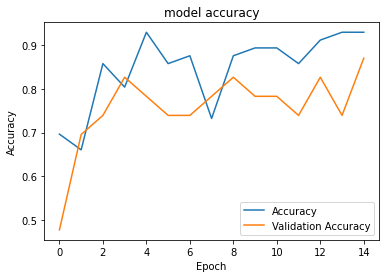

In [30]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Val Loss"])
plt.show()

In [31]:
model.save('model.h5')

In [40]:
from keras.models import load_model

saved_model = load_model('model.h5')

output = saved_model.predict(test_X)


ValueError: in user code:

    File "C:\Users\jujut\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\jujut\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jujut\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\jujut\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\jujut\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\jujut\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


In [33]:
submission = pd.read_csv('submission.csv')

for idx, row in enumerate(output):
    index = np.argmax(row)
    submission.at[idx, "class"] = index

submission.to_csv('submission.csv', index=False)

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
Possible improvements:
- grid search to study the best parameterz on a validation set
- preprocessing (normalization, ecc.)

For HOG/SIFT explanation link on the assignment pdf.

HOG performances with default parameters : 0.84581 (with GaussianBlur)
SIFT performances with default parameters : 0.69913

In [ ]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, blockSize = (40,40), blockStride = (20,20), cellSize = (20,20), nbins = 18, derivAperture = 1
, winSigma = -1, histogramNormType = 0, L2HysThreshold = 0.2, gammaCorrection = 1, nlevels = 64, signedGradients = True):
        self.blockSize = blockSize
        self.blockStride = blockStride
        self.cellSize = cellSize
        self.nbins = nbins
        self.derivAperture = derivAperture
        self.winSigma = winSigma
        self.histogramNormType = histogramNormType 
        self.L2HysThreshold = L2HysThreshold
        self.gammaCorrection = gammaCorrection
        self.nlevels = nlevels
        self.signedGradients = signedGradients         
        
    def transform(self, X):
        X = X.astype(np.uint8)
        hog = cv2.HOGDescriptor((X.shape[1], X.shape[2]), self.blockSize, self.blockStride, self.cellSize, self.nbins,
                                self.derivAperture, self.winSigma, self.histogramNormType,self.L2HysThreshold,
                                self.gammaCorrection, self.nlevels, self.signedGradients)
        descriptors = []
        resultimage = np.zeros((FACE_SIZE[0], FACE_SIZE[1]))

        for x in X:
            img = cv2.GaussianBlur(x, (5,5), 0)
            descriptors.append(hog.compute(img))

        descriptors = np.array(descriptors)
        descriptors = np.resize(descriptors, (descriptors.shape[0], descriptors.shape[1]))
        return descriptors   

In [ ]:
class SIFTFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, nfeatures=200, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6, n_clusters = 200):
        self.nfeatures = nfeatures
        self.nOctaveLayers = nOctaveLayers
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold 
        self.sigma = sigma
        self.flag = 1 # 1 for train set, 0 for test 
        self.n_clusters = n_clusters
        self.bow = []
    
    def extract_sift_features(self, list_image):

        image_descriptors = []
        sift = cv2.SIFT_create()
        for image in list_image:        
            _, descriptor = sift.detectAndCompute(image, None)
            image_descriptors.append(descriptor)

        return image_descriptors

    def kmean_bow(self, all_descriptors, n_clusters):
        bow_dict = []

        kmeans = KMeans(n_clusters = n_clusters)
        kmeans.fit(all_descriptors)

        bow_dict = kmeans.cluster_centers_
        self.bow = bow_dict
        
        return bow_dict

    def create_feature_bow(self, image_descriptors, BoW, n_clusters):

        X_features = []

        for i in range(len(image_descriptors)):
            features = np.zeros(n_clusters)

            if image_descriptors[i] is not None:
                distance = cdist(image_descriptors[i], BoW)

                argmin = np.argmin(distance, axis = 1)

                for j in argmin:
                    features[j] += 1
            X_features.append(features)

        return X_features

        
    def transform(self, X):  
        
        X = X.astype(np.uint8)
        
        image_descriptors = self.extract_sift_features(X)
        
        # train mode
        if self.flag == 1: 
            all_descriptors = []
            for descriptor in image_descriptors:
                if descriptor is not None:
                    for des in descriptor:
                        all_descriptors.append(des)

            BoW = self.kmean_bow(all_descriptors, self.n_clusters)
            
            self.flag = 0 #switch to test mode
            
            return self.create_feature_bow(image_descriptors, BoW, self.n_clusters)
        
        # test mode
        elif self.flag == 0:
            return self.create_feature_bow(image_descriptors, self.bow, self.n_clusters)


### 1.1.1. t-SNE Plots

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

hog = HOGFeatureExtractor()

X_embedded = TSNE().fit_transform(hog.transform(train_X))

plt.ylim([-200, 200])
plt.xlim([-200,200])
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=train_y, legend='full')

### 1.1.2. Discussion
Class 1 and 2 are well separated. Difficult discrimination between class 0-1 and 0-2.

## 1.2. Baseline 2: PCA feature extractor

Number of features can be determined by n_components (which depends on the number of images in the training data) or the percentage of variance to be retained.

Not many parameters can be improved.

PCA performances with default parameters : 0.77843

In [ ]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, train_X, n_components = None, var = 0.95):
        train_X = train_X.astype(np.uint8)
        gray_train_X = []
        
        #code to ensure grayscale conversion
        if len(train_X) > 3 and train_X.shape[3] > 1:
            for x in train_X:
                gray_train_X.append(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))
                
        gray_train_X = np.array(gray_train_X)
        
        self.n_components = n_components
        self.variance = var
        #mean image computation
        mean_image = gray_train_X.mean(axis=0)
        #centered_data computation
        centered_train = gray_train_X - mean_image
        
        m = train_X.shape[0]
        d = FACE_SIZE[0] * FACE_SIZE[1]
        images_matrix = np.reshape(centered_train, (m, d))
        if n_components == None:
            self.pca = PCA(n_components=var, svd_solver="full", whiten=True).fit(images_matrix)
        else:
            self.pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(images_matrix)
            
        
    def transform(self, X):
        X = X.astype(np.uint8)        
        gray_X = []
        
        #code to ensure grayscale conversion
        if len(X.shape) == 4:
            m = X.shape[0]
            if X.shape[3] > 1:
                for x in X:
                    gray_X.append(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))
            else:
                gray_X = np.array(X)
            
            gray_X = np.array(gray_X)
        else:
            if len(X.shape) > 2 and X.shape[2] > 1:
                 gray_X = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
            m = 1
        d = FACE_SIZE[0] * FACE_SIZE[1]
        gray_X = np.reshape(gray_X, (m, d))
        return self.pca.transform(gray_X)
        
    def inverse_transform(self, X):
        data = self.pca.inverse_transform(X)
        n_images = int(data.size / (FACE_SIZE[0]*FACE_SIZE[1]))
        
        data = np.array(data, dtype=np.uint8)
        
        if n_images > 1:
            return np.reshape(data, (n_images, FACE_SIZE[0], FACE_SIZE[1]))
        return np.reshape(data, (FACE_SIZE[0], FACE_SIZE[1]))

### 1.2.1. Eigenface Plots

In [ ]:
image = train_X[9]

max_eigenvectors = train_X.shape[0]

used_eigenvalues = np.linspace(10, max_eigenvectors, int(max_eigenvectors/10), dtype=int)[::-1]

eigenfaces_images = np.zeros((int(max_eigenvectors/10), FACE_SIZE[0], FACE_SIZE[1], 3))

for components in used_eigenvalues:
    pca = PCAFeatureExtractor(train_X, components)
    reduced_data = pca.transform(image)
    reconstructed_data = pca.inverse_transform(reduced_data)
    idx = int((max_eigenvectors - components) / 10)
    eigenfaces_images[idx] = cv2.cvtColor(reconstructed_data, cv2.COLOR_GRAY2RGB)
    
plot_image_sequence(eigenfaces_images, n=eigenfaces_images.shape[0], imgs_per_row=10)  
    

### 1.2.2. Feature Space Plots

In [ ]:
pca = PCAFeatureExtractor(train_X, 2)

reduced_data = pca.transform(train_X)

plt.plot(reduced_data[:,0][train_y == 0], reduced_data[:,1][train_y == 0], 'o', label="False")
plt.plot(reduced_data[:,0][train_y == 1], reduced_data[:,1][train_y == 1], 'o', label="Jesse Eisemberg")
plt.plot(reduced_data[:,0][train_y == 2], reduced_data[:,1][train_y == 2], 'o', label="Mila Kunis")
plt.title("Projecting the images in the 2D eigenspace")
plt.legend()
plt.figure()

### 1.2.3. Discussion

Again class 1 and 2 are well separated, while discrimination is difficult between class 0-1 and 0-2.

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """ 
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: SVM classifier
Two binary classifiers (usually work better for SVM).

Randomized search for the estimation of the best hyperparameters.

RBF kernel to obtain non-linear decision boundaries.

In [ ]:
class SVMClassificationModel:
    
    def fit(self, X, y):
        #Jesse classifier
        Y_jesse = np.array(y)
        Y_jesse[Y_jesse == 2] = 0
        
        param_grid = {
            "C": loguniform(1e3, 1e5),
            "gamma": loguniform(1e-4, 1e-1),
        }
        clf_jesse = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced", random_state=9), param_grid, n_iter=1000, cv=20, random_state=9
        )
        clf_jesse = clf_jesse.fit(X, Y_jesse)
        self.C_jesse = clf_jesse.best_estimator_.C
        self.gamma_jesse = clf_jesse.best_estimator_.gamma
        self.clf_jesse = clf_jesse
        
        #Mila classifier
        Y_mila = np.array(y)
        Y_mila[Y_mila == 1] = 0
        
        clf_mila = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced", random_state=9), param_grid, n_iter=1000, cv=10, random_state=9
        )
        clf_mila = clf_mila.fit(X, Y_mila)
        self.C_mila = clf_mila.best_estimator_.C
        self.gamma_mila = clf_mila.best_estimator_.gamma
        self.clf_mila = clf_mila
        
    def predict(self, X):
        
        y_jesse = self.clf_jesse.predict(X)
        y_mila = self.clf_mila.predict(X)
        
        y = np.zeros(y_jesse.size, dtype=int)
        
        y[np.logical_and(y_jesse == 1, y_mila == 0)] = 1
        y[np.logical_and(y_jesse == 0, y_mila == 2)] = 2
        
        #random choice when both Mila and Jesse are predicted
        y[np.logical_and(y_jesse == 1, y_mila == 2)] = np.random.randint(0,2)
        for i in range(y.size):
            if y_jesse[i] == 1 and y_mila[i] == 2:
                print("ERROR: both Jesse and Mila labels are predicted")
                
        y_with_four_labels = np.array(y, dtype=int)
        y_with_four_labels[np.logical_and(y_jesse == 1, y_mila == 2)] = 3
        
        return y, y_with_four_labels
    
    def __call__(self, X):
        return self.predict(X)

## 3.2. Baseline 2: Voting among SVM classifiers

Voting among the three classifiers that use HOG, SIFT and PCA features.

Surprisingly, it does not work well.

In [ ]:
class VotingClassificationModel:
        
    def fit(self, X, y):
        hog_features = X[0]
        sift_features = X[1]
        pca_features = X[2]
        
        self.hog_classifier = SVMClassificationModel()
        self.hog_classifier.fit(hog_features, y)
        
        self.sift_classifier = SVMClassificationModel()
        self.sift_classifier.fit(sift_features, y)
        
        self.pca_classifier = SVMClassificationModel()
        self.pca_classifier.fit(pca_features, y)
        
    def predict(self, X):
        hog_features = X[0]
        sift_features = X[1]
        pca_features = X[2]
        y_hog, y_four_hog = self.hog_classifier.predict(hog_features)
        y_sift, y_four_sift = y_mila_sift = self.sift_classifier.predict(sift_features)
        y_pca, y_four_pca = self.pca_classifier.predict(pca_features)
        
        self.c0 = self.c1 = self.c2 = self.c3 = self.c4 = 0
        y_final = -1*np.zeros((y_hog.size), dtype=int)
        
        for i in range(y_hog.size):
            values = np.array([y_four_hog[i], y_four_sift[i], y_four_pca[i]])
            
            n_zeros = np.where(values == 0, 1, 0).sum()
            n_ones = np.where(values == 1, 1, 0).sum()
            n_twos = np.where(values == 2, 1, 0).sum()
            n_threes = np.where(values == 3, 1, 0).sum()
            
            if n_zeros >= 2:
                y_final[i] = 0
            elif n_ones >= 2:
                y_final[i] = 1
            elif n_twos >= 2:
                y_final[i] = 2
            elif n_threes >= 2:
                self.c0 += 1
                y_final[i] = y_hog[i]
            elif n_ones == 1 and n_twos == 1 and n_zeros == 1:
                self.c1 += 1
                y_final[i] = y_hog[i]
            elif n_ones == 1 and n_zeros == 1 and n_threes == 1:
                self.c2 += 1
                y_final[i] = y_hog[i]
            elif n_zeros == 1 and n_twos == 1 and n_threes == 1:
                self.c3 += 1
                y_final[i] = y_hog[i]
            elif n_ones == 1 and n_twos == 1 and n_threes == 1:
                self.c4 += 1
                y_final[i] = y_hog[i]
                
        return y_final
    def __call__(self, X):
        y = self.predict(X)
        print(self.c0)
        print(self.c1)
        print(self.c2)
        print(self.c3)
        print(self.c4)
        return y

## 3.2. Baseline: My favorite classifer
Up to now, the best performing classifier is the SVM with HOG features.

A possible improvement can be the VGG ImageNet with Data Augmentation. As you can read on https://arxiv.org/pdf/1804.06655.pdf, this NN approach should be the best performing.

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

## 4.1. SVM model: basic pipeline

### 4.1.1. SVM model: HOGFeatureDescriptor

In [ ]:
feature_extractor = HOGFeatureExtractor() 
classifier_hog = SVMClassificationModel()

# train the model on the features
classifier_hog.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model_hog = lambda X: classifier_hog(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_hog, _ = model_hog(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_hog))

In [ ]:
# predict the labels for the test set 
test_y_hog, _ = model_hog(test_X)

### 4.1.2. SVM model: SIFTFeatureDescriptor

In [ ]:
feature_extractor = SIFTFeatureExtractor() 
classifier_sift = SVMClassificationModel()

# train the model on the features
classifier_sift.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model_sift = lambda X: classifier_sift(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_sift, _ = model_sift(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_sift))

In [ ]:
# predict the labels for the test set 
test_y_sift, _ = model_sift(test_X)

### 4.1.3. SVM model: PCAFeatureDescriptor

In [ ]:
feature_extractor = PCAFeatureExtractor(train_X) 
classifier_pca = SVMClassificationModel()

# train the model on the features
classifier_pca.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model_pca = lambda X: classifier_pca(feature_extractor(X))

In [ ]:
#### evaluate performance of the model on the training set
train_y_pca, _ = model_pca(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_pca))

In [ ]:
# predict the labels for the test set 
test_y_pca, _ = model_pca(test_X)

## 4.2. Voting model: voting among SVM classifiers

In [ ]:
feature_extractor_hog = HOGFeatureExtractor() 
feature_extractor_sift = SIFTFeatureExtractor() 
feature_extractor_pca = PCAFeatureExtractor(train_X) 

classifier = VotingClassificationModel()

# train the model on the features
classifier.fit([feature_extractor_hog(train_X), feature_extractor_sift(train_X), feature_extractor_pca(train_X)], train_y)

# model/final pipeline
model = lambda X: classifier([feature_extractor_hog(X), feature_extractor_sift(X), feature_extractor_pca(X)])

In [ ]:
# predict the labels for the test set 
test_y = model(test_X)

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_hog

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
